In [8]:
from utils import *

from glob import glob
from tqdm import tqdm

# Start

In [9]:
K = 2
PADDING_SIZE = 0
ROI_OFFSET = 40

In [10]:
def vertices_all_inside_image_or_corners(vertices, image_shape):
    """TODO"""
    
    # print(vertices)
    corner_points = [[0, 0], [0, image_shape[0] - 1], [image_shape[1] - 1, image_shape[0] - 1], [image_shape[1] - 1, 0]]
    
    for vertex in vertices:
        
        found = False
        for i in range(len(corner_points)):
            cp = corner_points[i]
            if (vertex[0] == cp[0] and vertex[1] == cp[1]):
                found = True
                index = i
                break
        
        if found: 
            del corner_points[index]
    
    # print(corner_points)
    
    if len(corner_points) == 4 or len(corner_points) == 0:
        return True
    else:
        return False

In [11]:
def angle_cos(p0, p1, p2):
    
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

In [36]:
def find_roi_corner_points(image, plot=True):
    
    """TODO"""
    # adapted from: https://www.pyimagesearch.com/2014/04/21/building-pokedex-python-finding-game-boy-screen-step-4-6/

    image_area = image.shape[0] * image.shape[1]
    lb_area = image_area * 0.1
    ub_area = image_area * 0.99
    min_vertical_length = image.shape[0] * 0.1
    min_horizontal_length = image.shape[1] * 0.1
    
    # list of all the valid 4-vertices polygons found
    polygons_found = []
    
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html#bilateral-filtering
    bilateral_blur = cv2.bilateralFilter(image, 9, 75, 75) 

    # http://www.cse.msu.edu/~pramanik/research/papers/2002Papers/icip.hsv.pdf
    image_for_clustering = cv2.cvtColor(bilateral_blur, cv2.COLOR_BGR2HSV) 
    # image_for_clustering[:,:,2] += 100
    # min_brightness = np.min(image_for_clustering[:,:,2])
    # max_brightness = np.max(image_for_clustering[:,:,2])
    # x' = ((x - a) / (b - a)) * (b' - a')
    # image_for_clustering[:,:,2] = ((image_for_clustering[:,:,2] - min_brightness) / (max_brightness - min_brightness)) * (255)
    # print(list(image_for_clustering[:,:,2])[0])
    # image_for_clustering[:,:,2] = np.clip(image_for_clustering[:,:,2] + 30, 0, 255) # make independent of HSV' V value
    
    vectorized = image_for_clustering.reshape((-1,3))

    # convert to np.float32
    vectorized = np.float32(vectorized)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) #  ( type, max_iter, epsilon )
    _, label, _ = cv2.kmeans(vectorized, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) # alternative is cv2.KMEANS_PP_CENTERS
    
    if np.size(np.where(label == [1])) > np.size(np.where(label == [0])):
        COLORS = [[0, 0, 0], [255, 255, 255]]
    else:
        COLORS = [[255, 255, 255], [0, 0, 0]]
        
    colors = np.uint8(COLORS)

    # make image
    res = colors[label.flatten()]
    clustered_image = res.reshape((image.shape))

    # convert to grayscale and postprocess
    gray = cv2.cvtColor(clustered_image, cv2.COLOR_BGR2GRAY)
    # converting image to a binary image  
    # _, threshold = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY) 
    
    # https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    # threshold = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=1)
    # threshold = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel, iterations=1)

    # for each padding_color
    for padding_color in COLORS:
        
        # Add padding to the thresholded image
        padded_image = cv2.copyMakeBorder(gray.copy(),
                                          PADDING_SIZE, PADDING_SIZE, PADDING_SIZE, PADDING_SIZE,
                                          cv2.BORDER_CONSTANT, value=padding_color)
        
        # detecting shapes in image by selecting region with same colors or intensity 
        contours, _ = cv2.findContours(padded_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # cv2.RETR_TREE
        contours = sorted(contours, key=cv2.contourArea)
        contours = contours[5:]
        
        # Draw all detected contours
        contours_image = np.zeros((padded_image.shape[0], padded_image.shape[1], 1), np.uint8)
        contours_image = cv2.drawContours(cv2.cvtColor(contours_image,cv2.COLOR_GRAY2RGB), contours, -1, (0, 255, 0), 10)
        
        arc_lenght_percentages = np.flip(np.arange(0.05, 0.1, 0.01))
        # arc_lenght_percentages = np.arange(0.01, 0.1, 0.01)
        for arc_lenght_percentage in arc_lenght_percentages: # arc_lenght_percentages: 
            
            for contour in contours:

                area = cv2.contourArea(contour) 
                
                # skip contour is area is outside the limits
                if area < lb_area or area > ub_area: # or area <= max_poly_area:
                    continue
                
                # Use of Ramer–Douglas–Peucker algorithm:
                # https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm
                # epsilon is maximum distance from contour to approximated contour, it is an accuracy parameter.
                
                epsilon = arc_lenght_percentage * cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, epsilon, True)

                # square contours should have 4 vertices after approximation and be convex.
                if len(approx) == 4 and cv2.isContourConvex(approx):

                    poly = postprocess_polygon_vertices(approx, image.shape, PADDING_SIZE)
                    approx = approx.reshape(-1, 2)

                    # Find the maximum cosine of the angle between joint edges
                    max_cos = np.max([angle_cos( approx[i], approx[(i+1) % 4], approx[(i+2) % 4] ) for i in range(4)])

                    # if cosines of all angles not too large 
                    # (let's say that all angles are between 45 and 90 degree)
                    if (max_cos < 0.7):

                        # check sides length
                        b_l = poly[0, 0]
                        b_r = poly[1, 0]
                        t_l = poly[2, 0]
                        t_r = poly[3, 0]
                        
                        if not vertices_all_inside_image_or_corners([b_l, b_r, t_l, t_r], image.shape):
                            continue

                        bottom_horizontal_length = b_r[0] - b_l[0]
                        top_horizontal_length    = t_r[0] - t_l[0]
                        left_vertical_length     = t_l[1] - b_l[1]
                        right_vertical_length    = t_r[1] - b_r[1]

                        if ( bottom_horizontal_length > min_horizontal_length and
                             top_horizontal_length > min_horizontal_length and
                             left_vertical_length > min_vertical_length and
                             right_vertical_length > min_vertical_length):

                                # polygon_vertices = poly
                                # max_poly_area = area
                                polygons_found.append([poly, area, max_cos])

            # polygoins found, break from arc lenght percentage loop
            # if len(polygons_found) != 0:
            #    break
        
        # polygoins found, break from padding color loop
        if len(polygons_found) != 0:
            break
    
    # check if a polygon has been found
    if len(polygons_found) == 0: 
        # if not, then return a polygon big as the image
        internal_polygon_vertices = full_image_polygon(image.shape)[0]
        external_polygon_vertices = get_external_polygon_vertices(internal_polygon_vertices, image.shape, ROI_OFFSET)
    else:
        # order found polygons by decreasing area and increasing max_cos
        polygons_found = sorted(polygons_found, key = lambda x: (-x[1], x[2]))
        #for f in polygons_found:
        #    print(f)
        internal_polygon_vertices = polygons_found[0][0]
        external_polygon_vertices = get_external_polygon_vertices(internal_polygon_vertices, image.shape, ROI_OFFSET)
    
    
    if plot:
        # draw the polygon
        img_result = draw_rectangle(image.copy(), internal_polygon_vertices, color=(255, 0, 255), thickness=5) 
        img_result = draw_rectangle(img_result, external_polygon_vertices, color=(255, 255, 0), thickness=5)

        show_images([padded_image, contours_image, img_result[...,::-1]], titles=["color separated image", "contours detected", "approximated trapezoid"], figsize=(5,5)) 
    
    return internal_polygon_vertices, external_polygon_vertices

Processing ../dataset/images/CV20_image_6.png


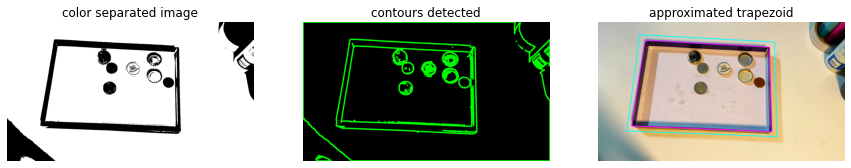

In [50]:
annotations_filenames = glob('../dataset/new_annotations/*.json')
images_filenames = glob('../dataset/images/*.png')

file_number = 6
image_filename = '../dataset/images/CV20_image_' + str(file_number) + '.png'

print("Processing", image_filename)
file_number = int(image_filename.split('_')[-1].split('.')[0])

# read image
image = cv2.imread(image_filename) 

# find roi corner points
internal_roi_vertices, external_roi_vertices = find_roi_corner_points(image, plot=True)
#points = find_roi_corner_points(image, plot=True)
#points = points.reshape((4, 2))

In [14]:
# save new annotation
# new_annotation = annotation.copy()
# new_annotation["imagePath"] = image_filename.split("\\")[1]
# new_annotation["imageData"] = None
# for k, shape in enumerate(new_annotation["shapes"]):
    # xmin, ymin, xmax, ymax, label = new_bounding_boxes[k]
#    if (shape["label"] == 'BottleCapFaceUp'):
#         shape["label"] = 'BottleCap_FaceUp'
#     elif (shape["label"] == 'BottleCapFaceDown'):
#        shape["label"] = 'BottleCap_FaceDown'
#     elif (shape["label"] == 'BottleCapDeformed'):
#         shape["label"] = 'BottleCap_Deformed'
#     # shape["points"] = [[xmin, ymin], [xmax, ymax]]
# 
# with open('../dataset/new_renamed_annotations/' + 'CV20_label_renamed_' + str(file_number) + '.json', 'w') as outfile:
#     json.dump(new_annotation, outfile, indent=4)

In [15]:
# save data

    # save new image
    # cv2.imwrite('./roi_images/' + 'CV20_image_' + str(file_number) + '.png', roi_image)

    ## TODO remove debug =========================================================================
    # plot warped bb on the warped image
    # roi_image_bb = roi_image.copy()
    # for bb in new_bounding_boxes:
    #     roi_image_bb = cv2.rectangle(roi_image_bb, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 3) 

    # save new image
    # cv2.imwrite('./roi_check/' + 'CV20_image_' + str(file_number) + '.png', roi_image_bb)
    # TODO remove debug ==========================================================================

    # print("Image saved")

In [291]:
# calculate the perspective transform matrix
# T, max_width, max_height = find_perspective_transf_matrix(points)

# warp the perspective to grab the ROI
# roi_image = cv2.warpPerspective(image, T, (max_width, max_height))

# get original image buinding boxes
# bounding_boxes = get_bounding_boxes(annotation)

# transform them in for the roi image
# new_bounding_boxes = warp_bounding_boxes(bounding_boxes, T)

In [292]:
# visualization

# plot them on the original image
# image_bb = image.copy()
# for bb in bounding_boxes:
#     image_bb = cv2.rectangle(image_bb, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 3) 

# plot warped bb on the warped image
# roi_image_bb = roi_image.copy()
# for bb in new_bounding_boxes:
#     roi_image_bb = cv2.rectangle(roi_image_bb, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 3) 

# show_images([image_bb[...,::-1], roi_image_bb[...,::-1]], titles=["original", "ROI bird-eye-view"], figsize=(5, 5))

In [51]:
# check if a bb is completely outside the detected roi, don't save the image
# if it is partially in, clip the box coordinates
#roi_ymax = roi_image.shape[0] - 1
#roi_xmax = roi_image.shape[1] - 1

#error = False
#for bb in new_bounding_boxes:
#    xmin, ymin, xmax, ymax = bb[:4]
#    # check if bb is partially contained in 
#    cond_1 = xmin == xmax or ymin == ymax
#    cond_2 = not is_point_contained((xmin, ymin), roi_xmax, roi_ymax)
#    cond_3 = not is_point_contained((xmax, ymax), roi_xmax, roi_ymax)
#    if cond_1 or (cond_2 and cond_3):
#        error = True
#        break

#if error:
#    print("problem with transformation occurred, image skipped")
#    # continue # skip to next image
#else: 
#    # clip boxes to roi_image size
#    for k in range(len(new_bounding_boxes)):
#        xmin, ymin, xmax, ymax, label = new_bounding_boxes[k]
#        xmin = max(0, xmin)
#        ymin = max(0, ymin)
#        xmax = min(xmax, roi_xmax)
#        ymax = min(ymax, roi_ymax)
#        new_bounding_boxes[k] = [xmin, ymin, xmax, ymax, label]